## Imports 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import qiskit
from qiskit import QuantumCircuit, transpile, QuantumCircuit, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, DensityMatrix, Operator
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from math import gcd

# Grover's Algorithm 

## Define our Oracle and target state (marked state)

In [5]:
def quantum_oracle(num_qubits, marked_state):
    marked_state = marked_state[::-1]
    oracle = QuantumCircuit(num_qubits)
    
    """
     - Apply X gate on all 0 qubits in the marked state
    """
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    """
     - Apply hadamard gates on the last qubit 
     - flip the phase of the state if it is equal to the marked state using 
         multi controlled z-gate
    """
    control_qubits = list(range(num_qubits - 1))
    target_qubit = num_qubits - 1

    oracle.h(target_qubit)
    oracle.mcx(control_qubits, target_qubit)
    oracle.h(target_qubit)

    """
     - Undo the X Gates
    """    
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)
        
    return oracle

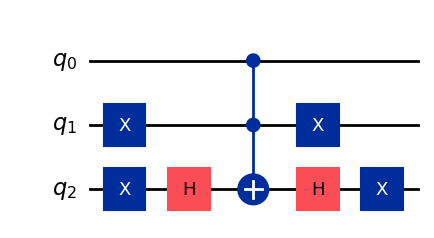

In [6]:
oracle = quantum_oracle(3, "001")
oracle.draw('mpl')

## Define our Diffusion Operator

In [8]:
# Diffusion operator (U_s)
def grover_diffusion_operator(num_qubits):

    """
     Initialise Diffusion Operator circuit :
        - This Operator amplifies the amplitude of the marked state 
          and suppresses the states that are not marked
        - # U_f = 2|ψ><ψ| - I
    """
    diff_operator = QuantumCircuit(num_qubits)

    """ 
    Hadamard Transform :
    Reflects phase about the average and amplifies the probability of the marked state
    """
    diff_operator.h(list(range(num_qubits)))
    diff_operator.x(list(range(num_qubits)))

    diff_operator.h(num_qubits - 1)
    diff_operator.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    diff_operator.h(num_qubits - 1)
    
    diff_operator.x(list(range(num_qubits)))
    diff_operator.h(list(range(num_qubits)))
    
    return diff_operator

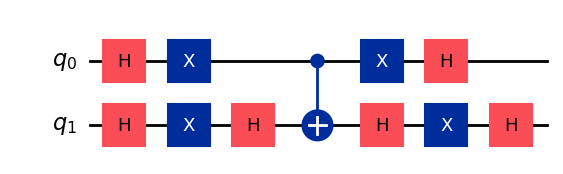

In [9]:
U_f = grover_diffusion_operator(2)
U_f.draw('mpl')

## Circuit Initialization

In [11]:
num_qubits = 3
marked_state = "001"

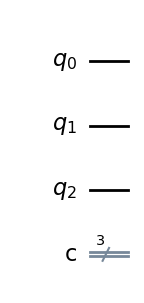

In [12]:
qc = QuantumCircuit(num_qubits,num_qubits)
qc.draw('mpl')

In [13]:
u = Statevector(qc)
u.draw('latex')

<IPython.core.display.Latex object>

## Introduce a uniform superposition of all basis states

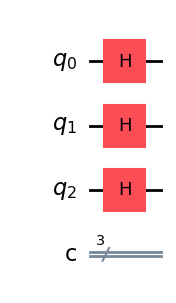

In [15]:
qc.h(list(range(num_qubits)))
qc.draw('mpl')

In [16]:
u = Statevector(qc)
u.draw('latex')

<IPython.core.display.Latex object>

## Measure and Find output counts 

In [18]:
oracle = quantum_oracle(num_qubits, marked_state)
diffuser = grover_diffusion_operator(num_qubits)

In [19]:
qv = Statevector(qc)
display(qv.draw('latex'))

<IPython.core.display.Latex object>

In [20]:
num_iterations = int(np.floor(np.pi/4 * np.sqrt(2**num_qubits)))
for i in range(num_iterations):
    qc.compose(oracle,inplace=True)
    qv = Statevector(qc)
    display(qv.draw('latex'))
    
    qc.compose(diffuser,inplace=True)
    qv = Statevector(qc)
    display(qv.draw('latex'))

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [21]:
qv = Statevector(qc)
display(qv.draw('latex'))

<IPython.core.display.Latex object>

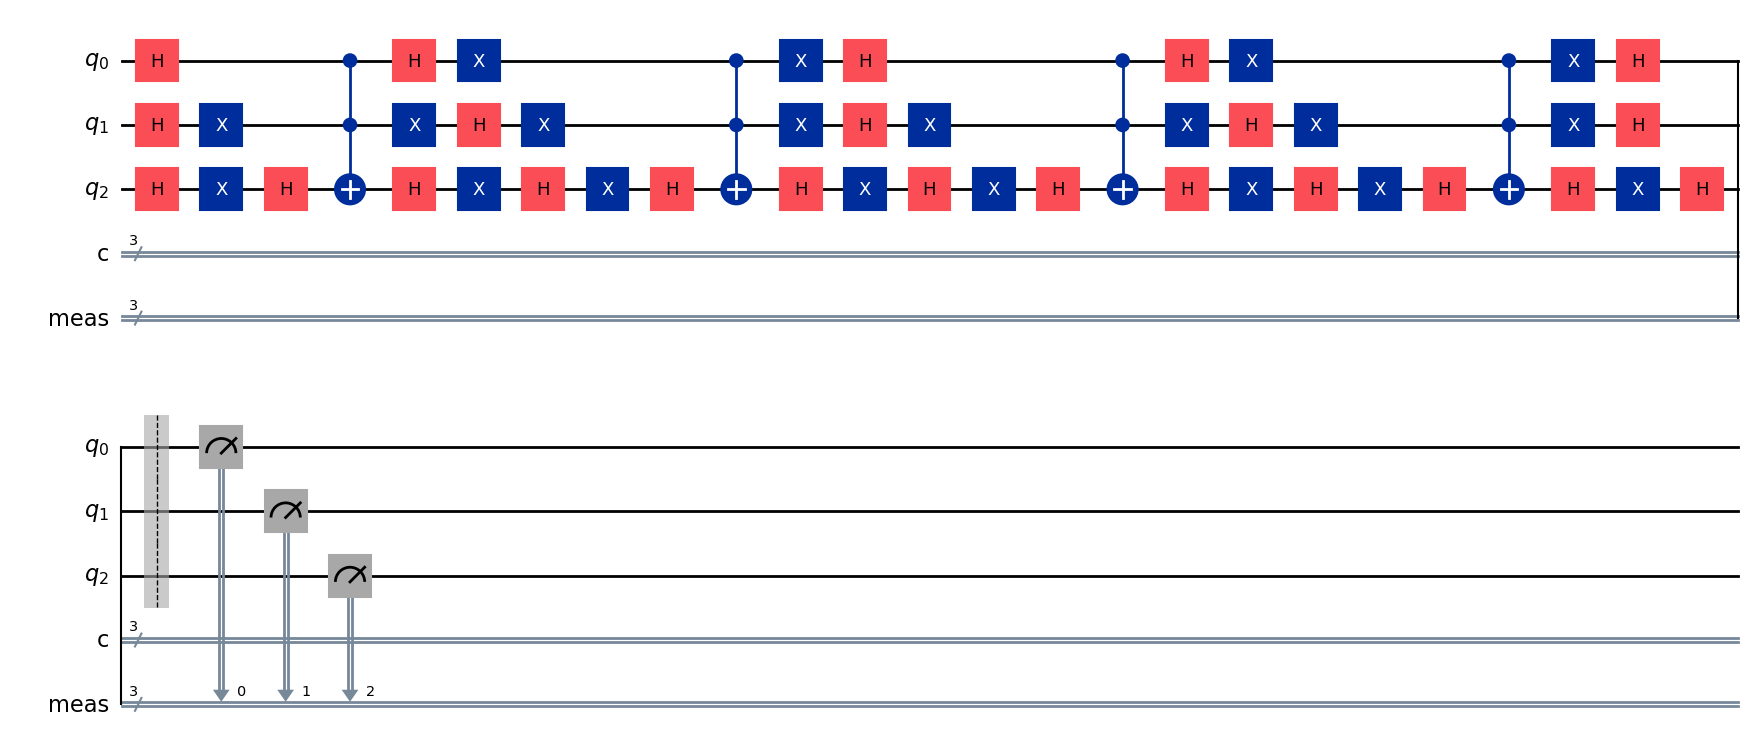

In [22]:
qc.measure_all()
display(qc.draw('mpl'))

In [23]:
backend = AerSimulator()

job = backend.run(qc, shots=1000)
result = job.result()

counts = result.get_counts()
print(counts)

{'100 000': 8, '000 000': 9, '101 000': 8, '001 000': 950, '011 000': 5, '010 000': 10, '110 000': 3, '111 000': 7}


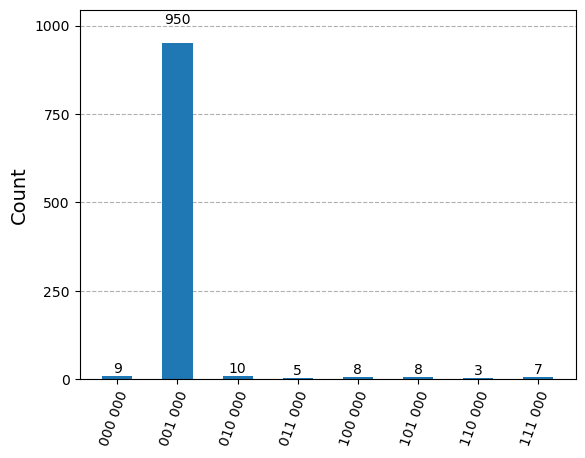

In [24]:
plot_histogram(counts)

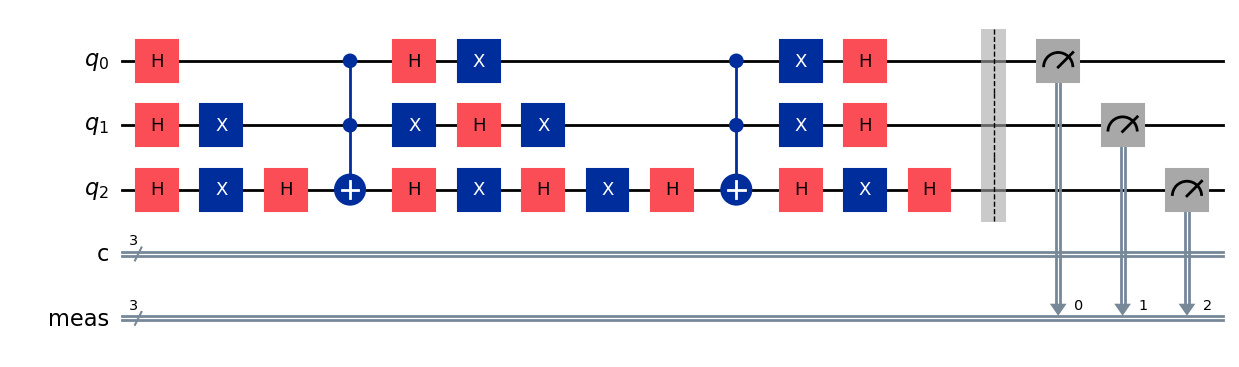

In [25]:
sample_circuit = QuantumCircuit(3,3)
sample_circuit.h([0, 1, 2])
sample_circuit.compose(oracle, inplace=True)
sample_circuit.compose(diffuser, inplace=True)
sample_circuit.measure_all()
sample_circuit.draw('mpl')